# Vehicle Detection
In this Jupyter Notebook, we will try to detect vehicles from images and videos feeds using computer vision and machine learning techniques.

The main objectivs of this project will be as follows:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train Linear SVM and Random Forest classifiers to compare the performance differences
* Apply a color transform and append binned color features, as well as histograms of color, and append to your HOG feature vector
* Normalize the features and randomize a selection for training and testing
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images
* Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles
* Estimate a bounding box for vehicles detected

## Getting Started
There are many features that we can consider extracting from an image or a video frame. We can first take a look at the images that we have in the training set.

In [334]:
## import needed packages
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.externals import joblib
from skimage.feature import hog
from tqdm import tqdm
from PIL import Image
from collections import deque
from itertools import chain

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

In [2]:
## import training images
veh_images = glob.glob('./training_images/vehicles/**/*.png')
nonveh_images = glob.glob('./training_images/non-vehicles/**/*.png')

print("Vehicle Images: "+str(len(veh_images)))
print("Non-vehicle Images: "+str(len(nonveh_images)))

Vehicle Images: 8792
Non-vehicle Images: 8968


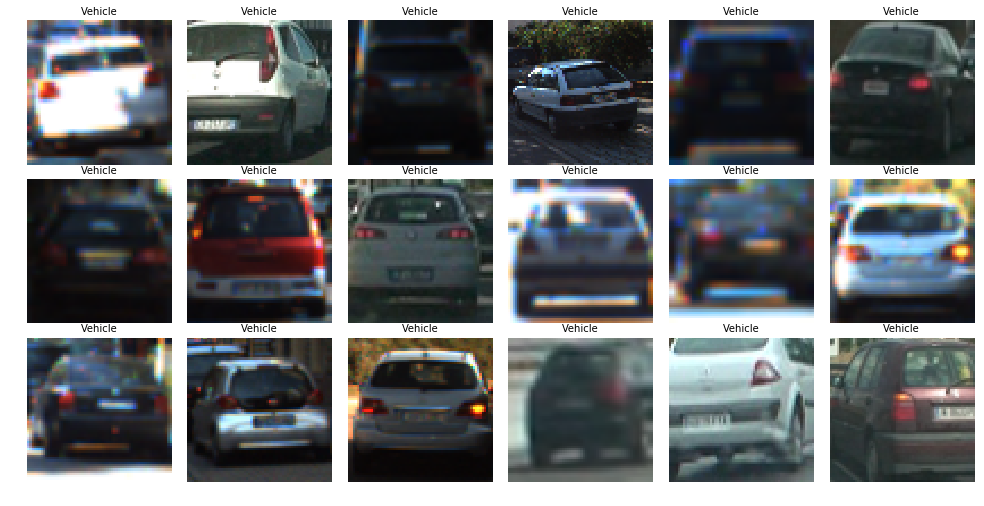

In [3]:
## plot vehicles
f, ax = plt.subplots(3,6, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(18):
    img1 = cv2.imread(veh_images[np.random.randint(0,len(veh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Vehicle', fontsize=10)
    ax[i].imshow(img1)
    
## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/vehicles.png")

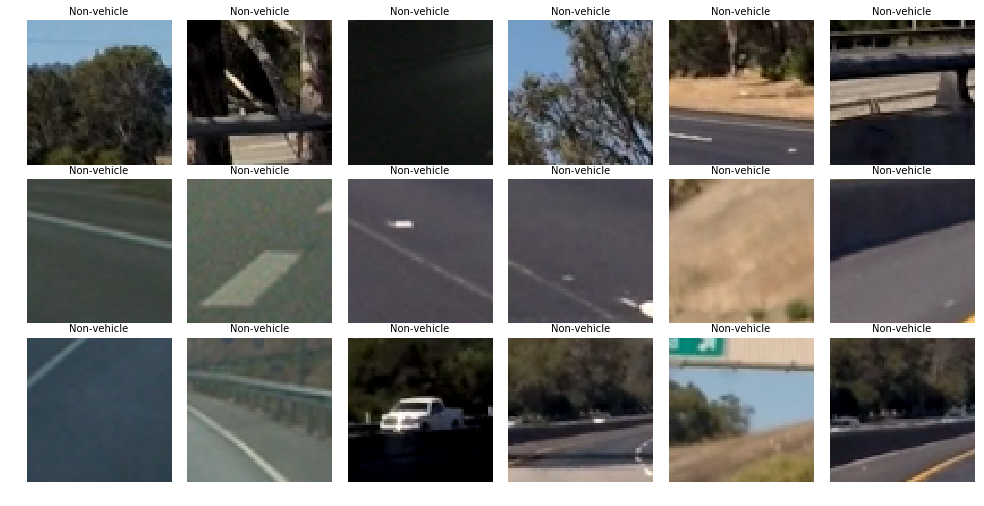

In [4]:
## plot non-vehicles
f, ax = plt.subplots(3,6, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(18):
    img1 = cv2.imread(nonveh_images[np.random.randint(0,len(nonveh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Non-vehicle', fontsize=10)
    ax[i].imshow(img1)
    
## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/non_vehicles.png")

As expected, the images above show cars are various zooms, crops, and angles while the non-vehicle images show scenes do not contain any cars. We can use these images to extract relevant features, which will ultimately be used to train our classifier. 

[(947, 578), (877, 619)]


/Users/jwen/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  del sys.path[0]


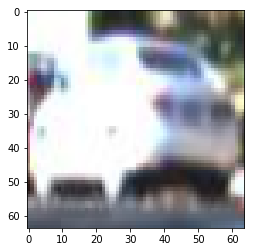

In [17]:
## using additional images from https://github.com/udacity/self-driving-car/tree/master/annotations
labels_df = pd.read_csv("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/training_images/crowdai_labels.csv")
car_labels = labels_df[labels_df['Label']=='Car'].reset_index()

car_labels['window'] = car_labels.apply(lambda x: [(x['ymin'],x['xmax']),(x['xmin'], x['ymax'])], axis=1)
car_labels

## test to see new images
img_idx = 62437

## read in image
crowdai_path = "/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/training_images/object-detection-crowdai/"
image = cv2.imread(crowdai_path+car_labels.ix[img_idx,'Frame'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

extracted_image = draw_boxes(image, [car_labels.ix[img_idx,'window']])
print(car_labels.ix[img_idx,'window'])

plt.imshow(extracted_image)
blah = cv2.resize(image[car_labels.ix[img_idx,'window'][0][1]:car_labels.ix[img_idx,'window'][1][1], 
                        car_labels.ix[img_idx,'window'][1][0]:car_labels.ix[img_idx,'window'][0][0]], (64, 64))

plt.imshow(blah)


In [122]:
## function to extract car images from crowd ai iamges
def save_additional_cars(car_labels_df, area_thresh=22500, base_path="/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/training_images/"):
    
    ## set paths
    crowdai_path = base_path + 'object-detection-crowdai/'
    additional_imgs = base_path + 'additional_vehicles/'

    ## iterate through the list of images
    for i, file in tqdm(enumerate(car_labels_df['Frame'])):

        try:
            ## image features
            img_features = []

            ## read in each one by one
            img = mpimg.imread(crowdai_path+car_labels_df.ix[i,'Frame'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            ## resize images
            img = cv2.resize(img[car_labels_df.ix[i,'window'][0][1]:car_labels_df.ix[i,'window'][1][1], 
                                car_labels_df.ix[i,'window'][1][0]:car_labels_df.ix[i,'window'][0][0]], (64, 64))
            
            if np.abs((car_labels_df.ix[i,'window'][0][1]-car_labels_df.ix[i,'window'][1][1]) * 
                      (car_labels_df.ix[i,'window'][1][0]-car_labels_df.ix[i,'window'][0][0])) > area_thresh:
                cv2.imwrite(additional_imgs+file,img)
                
        except:
            continue
            
def color_equalizer(imgs, base_path="/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/training_images/"):
    
    ## image paths
    additional_imgs = base_path + 'additional_vehicles_equal/'
    
    ## read in the images in a loop
    for i in tqdm(imgs):
        
        file_name = i.split('/')[-1]
        
        ## reading images
        img = cv2.imread(i, 1)

        ## converting
        lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        ## split image colors
        l, a, b = cv2.split(lab)

        ## apply clahe
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)

        ## merge color channels together
        limg = cv2.merge((cl,a,b))

        ## convert back to RGB
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        
        cv2.imwrite(additional_imgs+file_name,final)
        
def convert_to_png(imgs):
    
    ## read in the images in a loop
    for i in tqdm(imgs):
        
        ## read in image
        im = Image.open(i)
        
        ## save as png
        im.save(i[:-4]+'.png', "PNG")

In [ ]:
## save additional images
save_additional_cars(car_labels)

56649it [2:20:08, 19.33s/it] 

In [27]:
## import additional training images to be equalized
add_veh_images = glob.glob('./training_images/additional_vehicles/*.jpg')

## equalize additional images
color_equalizer(add_veh_images)

100%|██████████| 6251/6251 [00:04<00:00, 1352.58it/s]


In [125]:
## import additional training images
add_veh_images = glob.glob('./training_images/additional_vehicles_equal/*.png')

## use once to turn jpg to png
#convert_to_png(add_veh_images)

print("Additional Vehicle Images: "+str(len(add_veh_images)))

Additional Vehicle Images: 6251


## Extracting Features
### Histogram of Gradients
First, we can try to extract the histogram of gradients. The gradients of an image will help to identify the structures within the image. On the otherhand, if we use color, it might be difficult to extract the relavant features because the same model car can be different colors. The gradient is able to capture the edges of the shape of the car. We use a modified version that averages the gradients across multiple cells to account for some possible noise in the image.

In [8]:
## hog extractor function (from exercise) to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

/Users/jwen/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


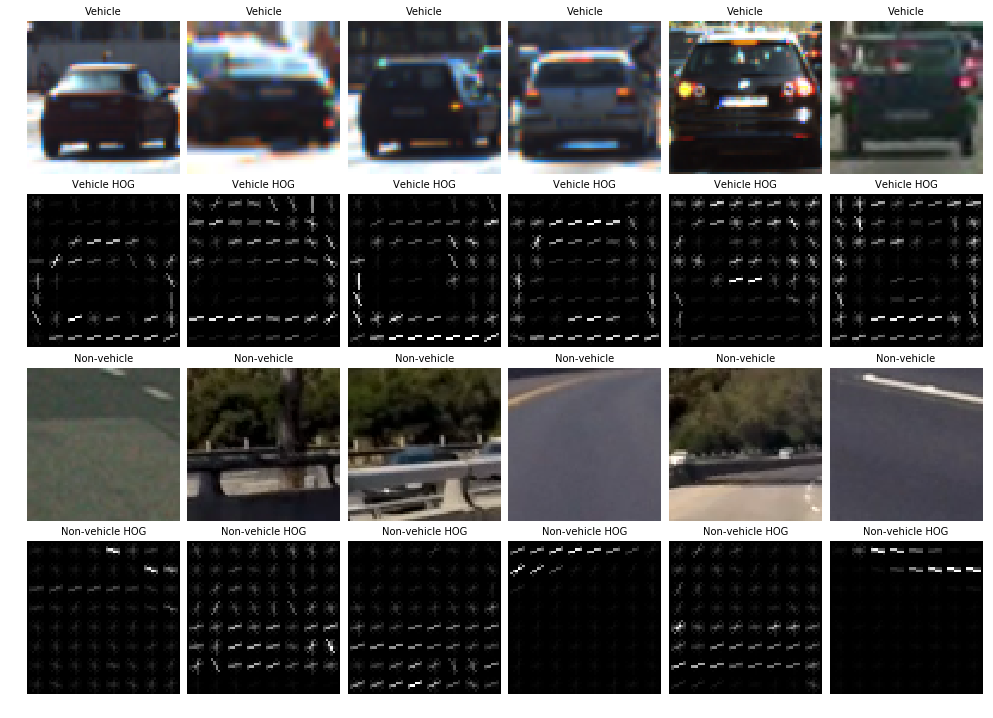

In [9]:
## plot images
f, ax = plt.subplots(4,6, figsize=(14, 10))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()
    
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Step through the list and search for chessboard corners
for i in range(6):
    ## plot img
    img1 = cv2.imread(veh_images[np.random.randint(0,len(veh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Vehicle', fontsize=10)
    ax[i].imshow(img1)
    
    ## plot hog
    gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    _, hog_img = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    ax[i+6].axis('off')
    ax[i+6].set_title('Vehicle HOG', fontsize=10)
    ax[i+6].imshow(hog_img, cmap='gray')

# Step through the list and search for chessboard corners
for i in range(12,18):
    ## plot img
    img1 = cv2.imread(nonveh_images[np.random.randint(0,len(nonveh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Non-vehicle', fontsize=10)
    ax[i].imshow(img1)
    
    ## plot hog
    gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    _, hog_img = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    ax[i+6].axis('off')
    ax[i+6].set_title('Non-vehicle HOG', fontsize=10)
    ax[i+6].imshow(hog_img, cmap='gray')
    
## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/hog_examples.png")

Awesome, we can look closely at the HOG visualizations and see that the gradients seem to capture the shape of the vehicles quite well. If we compare the HOG visualizations of the vehicles vs. the non-vehicles, we can see that there is a difference between the different types of images.

Next, we can explore another set of features: color.

### Color Related Features
We can imagine that the color of vehicles will be slightly different when compared to the non-vehicle images. Specifically, in some cases the vehicles are usually more saturated when compared to a pale background. Let's take a closer look and use a function to extract the color histogram of the image.

In [10]:
## function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    ## compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    ## generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    ## concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # return the individual histograms, bin_centers, and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

<Container object of 32 artists>

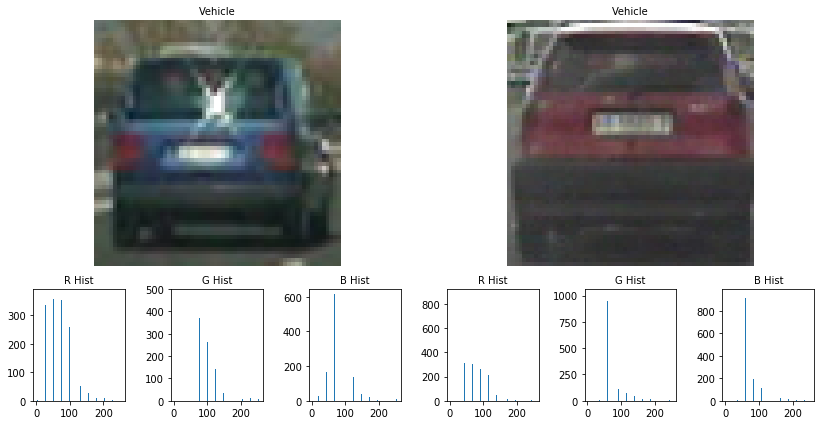

In [11]:
## setup figure
f = plt.figure(figsize=(14, 7))
f.subplots_adjust(hspace = .2, wspace=.5)

## read image 1
img1 = cv2.imread(veh_images[200])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(img1, nbins=32, bins_range=(0, 256))

## plot image
ax1 = plt.subplot2grid((3,6), (0,0), rowspan=2, colspan=3)
ax1.axis('off')
ax1.set_title('Vehicle', fontsize=10)
ax1.imshow(img1)

## R Hist
ax3 = plt.subplot2grid((3,6), (2,0))
ax3.set_title('R Hist', fontsize=10)
ax3.bar(bincen, rh[0])

## G hist
ax4 = plt.subplot2grid((3,6), (2,1))
ax4.set_title('G Hist', fontsize=10)
ax4.bar(bincen, gh[0])

## b hist
ax5 = plt.subplot2grid((3,6), (2,2))
ax5.set_title('B Hist', fontsize=10)
ax5.bar(bincen, bh[0])


## read image 2
img1 = cv2.imread(veh_images[2130])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(img1, nbins=32, bins_range=(0, 256))

## plot image
ax2 = plt.subplot2grid((3,6), (0,3), rowspan=2, colspan=3)
ax2.axis('off')
ax2.set_title('Vehicle', fontsize=10)
ax2.imshow(img1)

## R Hist
ax6 = plt.subplot2grid((3,6), (2,3))
ax6.set_title('R Hist', fontsize=10)
ax6.bar(bincen, rh[0])

## G hist
ax7 = plt.subplot2grid((3,6), (2,4))
ax7.set_title('G Hist', fontsize=10)
ax7.bar(bincen, gh[0])

## b hist
ax8 = plt.subplot2grid((3,6), (2,5))
ax8.set_title('B Hist', fontsize=10)
ax8.bar(bincen, bh[0])

## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/color_hist.png")

We can also take into account the raw pixel values. However, there might be too many features if we do that so we can reduce the size of the image to return a slightly lower resolution image with the same features.

In [12]:
# function to compute binned color features  
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    
    ## convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)             
    
    ## use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    
    return features

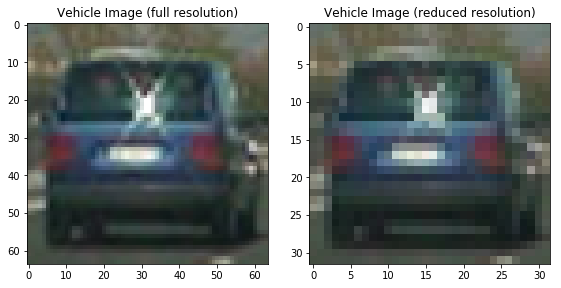

In [13]:
## read image 1
img1 = cv2.imread(veh_images[200])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

## take a look at the reduced resolution image
feature_vec = bin_spatial(img1, color_space='RGB', size=(32, 32))

## plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
f.tight_layout()

ax1.imshow(img1)
ax1.set_title('Vehicle Image (full resolution)', fontsize=12)

ax2.imshow(feature_vec.reshape((32,32,3)))
ax2.set_title('Vehicle Image (reduced resolution)', fontsize=12)

## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/spatial_bin.png")

We can see that in the above image the vehicle image on the right has a lower resolution but still captures most of the information that we see in the original image.

At this point we have quite a few techniques to extract both color and gradient information from the images. We can define a pipeline to extract these features. Note that if and when we combine the color and gradient features we need to normalize and scale the features so that the different scales of the features do not adversely affect the classifier that we will build.

In [232]:
## function to extract features
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                     spatial_feat=False, color_feat=False, hog_feat=True):
    ## create a list to append feature vectors to
    features = []
    
    ## iterate through the list of images
    for file in imgs:
        ## image features
        img_features = []
        
        ## read in each one by one
        img = mpimg.imread(file)
        
        ## apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)      
        
        ## get spatial binning features
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        
        ## get color features
        if color_feat:
            rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            img_features.append(hist_features)
        
        if hog_feat:
            ## get hog features
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features)
            
        ## append features to overall feature set
        features.append(np.concatenate(img_features))
        
    # Return list of feature vectors
    return features

## function to extract features from a single image
def single_img_features(img, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, color_feat=True, hog_feat=True):    
    
    ## define an empty list to receive features
    img_features = []
    
    ## apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
        
    ## spatial features
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    ## color features
    if color_feat:
        rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        img_features.append(hist_features)
        
    ## HOG features
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        ## append features to list
        img_features.append(hog_features)

    ## return concatenated array of features
    return np.concatenate(img_features)

## Classifying Images
With the pipeline for feature extraction built, we can build a classifier to see how the feature extraction and model performs. We will have to play with the different parameters to be able to identify the best set of parameters.

In [144]:
## define parameters for feature extraction
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0,256)
spatial_feat = True
color_feat = True
hog_feat = True

random.seed(999)

t=time.time()
## extract vehicle image features
car_features = extract_features(veh_images, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                color_feat=color_feat, hog_feat=hog_feat)

add_car_features = extract_features(add_veh_images, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                color_feat=color_feat, hog_feat=hog_feat)

car_features = car_features + add_car_features

print('Total vehicle images: ', len(car_features))

## extract non vehicle image features
notcar_features = extract_features(nonveh_images, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                   hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   color_feat=color_feat, hog_feat=hog_feat)

add_notcar_features = random.sample(notcar_features, 7000)

notcar_features = notcar_features + add_notcar_features

print('Total non-vehicle images: ', len(notcar_features)) 
t2 = time.time()

print(round(t2-t, 2), 'seconds to extract features')

/Users/jwen/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Total vehicle images:  15043
Total non-vehicle images:  15968
63.85 seconds to extract features


In [159]:
## combine observations
X = np.vstack((car_features, notcar_features)).astype(np.float64)

## fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
X_scaler = RobustScaler().fit(X)

## apply the scaler to X
scaled_X = X_scaler.transform(X)

## define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

## split up data into randomized training and test sets
rand_state = 22
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

## Model Training

In [160]:
## print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## use random forest
rf = RandomForestClassifier()

## check the training time for the RF
t=time.time()
rf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train RF')

## check the score of the RF
print('Test Accuracy of RF = ', round(rf.score(X_test, y_test), 4))

## check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', rf.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RF')

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
15.86 seconds to train RF
Test Accuracy of RF =  0.9906
Model predicts:  [ 1.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
Actual labels:   [ 1.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
0.00306 Seconds to predict 10 labels with RF


We can use grid search to find the best parameters for our random forest model.

In [20]:
## random forest with grid search
## set of parameters to try in grid search for random forest
# param_grid = {"n_estimators":[15,50,100],
#               "min_samples_split": [5,7,9],
#               "min_samples_leaf": [1,3,5],
#               "max_leaf_nodes": [None,3,5],
#               }

# rf = RandomForestClassifier(n_jobs=3)

# ## timer for grid searching
# t = time.time()
# rf = GridSearchCV(rf, param_grid, cv=3)
# rf.fit(X_train, y_train)
# t2 = time.time()
# print("Elapsed time for grid search cv: {}".format(t2-t))

# ## used with grid search
# print(rf.best_score_)
# print(rf.best_params_)

## best params: {'n_estimators': 50, 'max_leaf_nodes': None, 'min_samples_split': 7, 'min_samples_leaf': 1}
## best score: 0.992117117117

In [164]:
## print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## use random forest
rf_1 = RandomForestClassifier(n_estimators=50, min_samples_split=7, min_samples_leaf=1)

## check the training time for the RF
t=time.time()
rf_1.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train RF')

## check the score of the RF
print('Test Accuracy of RF = ', round(rf_1.score(X_test, y_test), 4))

## check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', rf_1.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RF')

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
63.33 seconds to train RF
Test Accuracy of RF =  0.9939
Model predicts:  [ 1.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
Actual labels:   [ 1.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
0.00641 Seconds to predict 10 labels with RF


In [165]:
## train the model on all of the data
rf_final = RandomForestClassifier(n_estimators=50, min_samples_split=7, min_samples_leaf=1)
rf_final.fit(scaled_X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=7, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

The grid search returned parameters that performed better than the standard model! We can also try to use gradient boosted trees, which are more robust.

In [ ]:
## print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## use random forest
gbc = GradientBoostingClassifier()

## check the training time for the GBC
t=time.time()
gbc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train GBC')

## check the score of the GBC
print('Test Accuracy of GBC = ', round(gbc.score(X_test, y_test), 4))

## check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', gbc.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with GBC')

It seems like the base version of the classifier without any parameter tuning performs better than the random forest; however, because it takes so long to train, it might be better to use the parameter turned random forest or the gradient boosted classifier without parameter tuning.

In [161]:
## print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## use SVC
svc = LinearSVC(loss='hinge')

## check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC')

## check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

## check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', svc.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432
27.05 seconds to train SVC
Test Accuracy of SVC =  0.9836
Model predicts:  [ 1.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
Actual labels:   [ 1.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
0.00188 Seconds to predict 10 labels with SVC


## Sliding Window
Now that our classifier can identify if an image or a frame of a video contains a car, we need to find a way to look through the image to search for potential car matches so that we can run it against our classfier. One idea is to use a sliding window approach to scan through the image to identify possible car-like objects, then pass it to our classifier.

In [233]:
## function that creates sliding windows (from lesson)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    ## if x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    ## compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    ## compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    ## compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    ## initialize a list to append window positions to
    window_list = []
    
    ## loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            
            ## calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            ## append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    return window_list

## function so search through an image
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    color_feat=True, hog_feat=True):

    ## create an empty list to receive positive detection windows
    on_windows = []
    
    ## iterate over all windows in the list
    for window in windows:
        
        ## extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        ## extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            color_feat=color_feat, hog_feat=hog_feat)
        
        ## scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        ## predict using your classifier
        prediction = clf.predict(test_features)
        ## if positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    ## return windows for positive detections
    return on_windows

## function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    ## make a copy of the image
    imcopy = np.copy(img)
    
    ## iterate through the bounding boxes
    for bbox in bboxes:
        
        ## draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    return imcopy

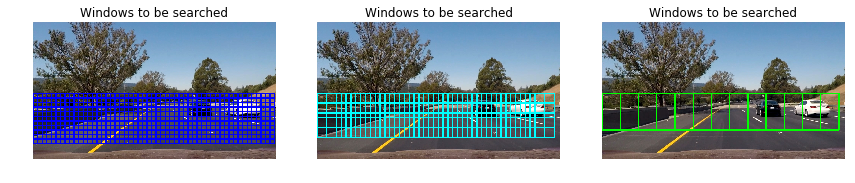

In [360]:
## read in the file paths to the test images
test_imgs = glob.glob('./test_images/*.jpg')

## read in image
image_orig = cv2.imread(test_imgs[5])
image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
image = image_orig.astype(np.float32)/255

## create boundary for search
y_start_stop = [375, 640]

## create windows to be searched
window_sizes = [96, 128, 192]
colors = [(0,0,255),(0,255,255),(0,255,0)]
windows_img = np.copy(image)
windows = []

for idx, window_size in enumerate(window_sizes):
    ## find windows at different scales
    temp_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_size, window_size), xy_overlap=(0.75, 0.75))
    
    ## adding the new windows
    windows += temp_windows

#     ## draw windows on the original image
#     windows_img = draw_boxes(windows_img, temp_windows, color=colors[idx])

## create windows
windows_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_sizes[0], window_sizes[0]), xy_overlap=(0.75, 0.75))
windows_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_sizes[1], window_sizes[1]), xy_overlap=(0.6, 0.6))
windows_3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_sizes[2], window_sizes[2]), xy_overlap=(0.5, 0.5))

## add windows to images
windows_1_img = draw_boxes(image_orig, windows_1, color=colors[0])
windows_2_img = draw_boxes(image_orig, windows_2, color=colors[1])
windows_3_img = draw_boxes(image_orig, windows_3, color=colors[2])

## plot the images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
f.tight_layout()

ax1.imshow(windows_1_img)
ax1.axis('off')
ax1.set_title('Windows to be searched', fontsize=12)

ax2.imshow(windows_2_img)
ax2.axis('off')
ax2.set_title('Windows to be searched', fontsize=12)

ax3.imshow(windows_3_img)
ax3.axis('off')
ax3.set_title('Windows to be searched', fontsize=12)

## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/search_windows_separate.png")

Next we can search the windows specified above for presence of vehicles.

/Users/jwen/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


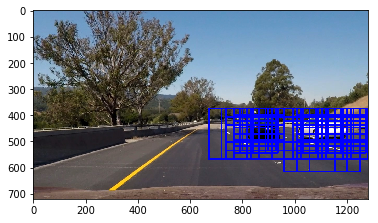

In [234]:
## search windows and classify cars
hot_windows = search_windows(image, windows, rf_final, X_scaler, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        color_feat=color_feat, hog_feat=hog_feat)                       

## draw boxes around possible cars
window_img = draw_boxes(image_orig, hot_windows)                    

plt.imshow(window_img)

# plt.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/located_cars.png")

In [333]:
## function to create heatmap
def add_heat(heatmap, bbox_list):
    
    ## iterate through list of bboxes
    for box in bbox_list:
        
        ## add += 1 for all pixels inside each bbox
        ## assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
## create a mask based on the heatmap
def apply_threshold(heatmap, threshold):
    
    ## zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

## final boxes around cars
def draw_labeled_bboxes(img, labels, ret_bbox=False):
    
    all_bbox = []
    
    ## iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        ## find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        ## identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        ## define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        ## draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        all_bbox.append(bbox)
        
    if ret_bbox:
        return img, all_bbox
    else:
        return img

## define a single function that can extract features
def find_cars(img, y_start_stop, window_sizes, clf, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
             hog_channel, spatial_feat, color_feat, hog_feat, test_flag=True, windows_flag=False, heat_flag=False):
    
    img_orig = np.copy(img)
    
    ## convert jpg for test images
    if test_flag:
        img = img_orig.astype(np.float32)/255
    
    ## create empty windows list
    windows = []
    
    ## varying overlap
    overlap = [0.75, 0.6, 0.5]

    for idx, window_size in enumerate(window_sizes):
        ## find windows at different scales
        temp_windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                               xy_window=(window_size, window_size), xy_overlap=(overlap[idx], overlap[idx]))

        ## adding the new windows
        windows += temp_windows
    
    ## search windows and classify cars
    hot_windows = search_windows(img, windows, clf, X_scaler, cspace=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                color_feat=color_feat, hog_feat=hog_feat)                       

    ## draw boxes around possible cars
    window_img = draw_boxes(img_orig, hot_windows)
    
    ## create empty heatmap
    heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

    ## add heat to each box in box list
    heatmap_mask = add_heat(heatmap_mask, hot_windows)

    ## apply threshold to help remove false positives
    heatmap_mask = apply_threshold(heatmap_mask,7)

    ## visualize the heatmap when displaying    
    heat_img = np.clip(heatmap_mask, 0, 255)

    ## find final boxes from heatmap using label function
    labels = label(heat_img)
    final_img = draw_labeled_bboxes(np.copy(img_orig), labels)
    
    if all([windows_flag,heat_flag]):
        return window_img, heat_img
    elif windows_flag:
        return window_img
    elif heat_flag:
        return heat_img
    else:
        return final_img

## function to convert color
def convert_color(img, conv='RGB2LUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    
## define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_efficient(img, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
                        hist_bins, test_flag=True, windows_flag=False, heat_flag=False):
    
    img_orig = np.copy(img)
    draw_img = np.copy(img)
    
    ## convert jpg for test images
    if test_flag:
        img = draw_img.astype(np.float32)/255
    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                bbox = ((xbox_left, ytop_draw+y_start_stop[0]), (xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0]))

                ## store the bounding box if its a car
                hot_windows.append(bbox)
                cv2.rectangle(draw_img,bbox[0], bbox[1],(0,0,255),6)
            
    
    ## create empty heatmap
    heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

    ## add heat to each box in box list
    heatmap_mask = add_heat(heatmap_mask, hot_windows)

    ## apply threshold to help remove false positives
    heatmap_mask = apply_threshold(heatmap_mask,3)

    ## visualize the heatmap when displaying    
    heat_img = np.clip(heatmap_mask, 0, 255)

    ## find final boxes from heatmap using label function
    labels = label(heat_img)
    final_img = draw_labeled_bboxes(np.copy(img_orig), labels)
         
    if all([windows_flag,heat_flag]):
        return draw_img, heat_img
    elif windows_flag:
        return draw_img
    elif heat_flag:
        return heat_img
    elif final_img is not None:
        return final_img
    else:
        return img

/Users/jwen/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


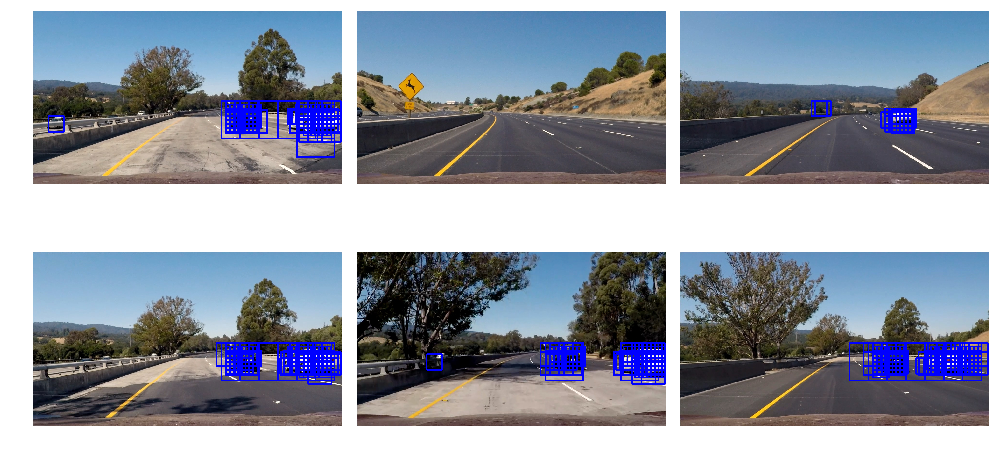

In [236]:
## set parameters
y_start_stop = [375, 640]
window_sizes = [64, 96, 156]
clf = rf_final
X_scaler = X_scaler

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0,256)
spatial_feat = True
color_feat = True
hog_feat = True

test_flag = True
windows_flag = True
heat_flag = False

## plot vehicles
f, ax = plt.subplots(2,3, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(6):
    ## read in image
    img1_orig = cv2.imread(test_imgs[i])
    img1_orig = cv2.cvtColor(img1_orig,cv2.COLOR_BGR2RGB)
    
    ## run the pipeline
    output_img = find_cars(img1_orig, y_start_stop, window_sizes, rf_final, X_scaler, color_space, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, hog_channel, spatial_feat, color_feat, hog_feat, 
                           test_flag, windows_flag, heat_flag)
    
    ## plot image
    ax[i].axis('off')
    ax[i].imshow(output_img)
    
## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/vehicle_final.png")

While the above function does a good job of finding cars, it is quite inefficient and slow. Namely, because we are scanning and running our HOG function (among others), it is a bit redundant. We can actually combine the different steps together to make things work faster.

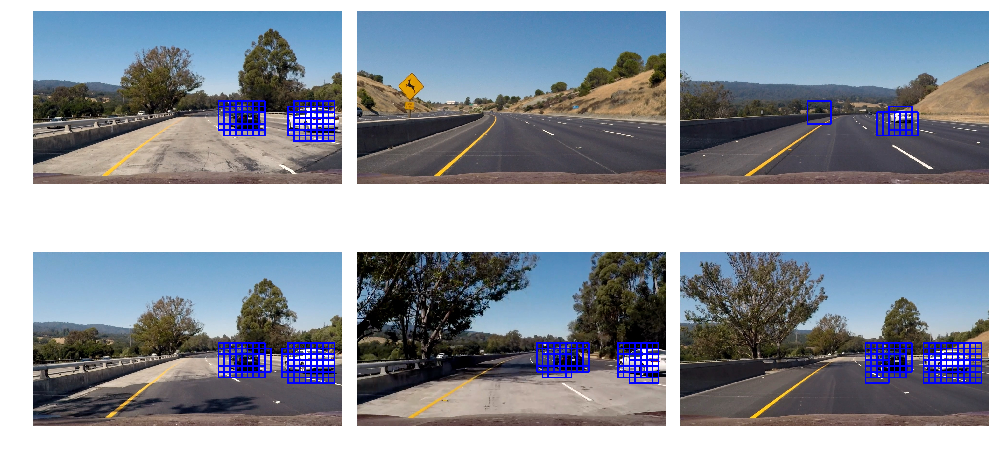

In [354]:
## set parameters
y_start_stop = [375, 640]
scale = 1.5
clf = rf_final
X_scaler = X_scaler
orient = 8
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0,256)
test_flag = True
windows_flag = True
heat_flag = False

## plot vehicles
f, ax = plt.subplots(2,3, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(6):
    ## read in image
    img1_orig = cv2.imread(test_imgs[i])
    img1_orig = cv2.cvtColor(img1_orig,cv2.COLOR_BGR2RGB)
    
    ## run the pipeline
    output_img = find_cars_efficient(img1_orig, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins, test_flag, windows_flag, heat_flag)
    
    ## plot image
    ax[i].axis('off')
    ax[i].imshow(output_img)
    
## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/vehicle_final_efficient.png")

The pipeline seems to find the cars fairly well on the test images. However, we see that there is still a little bit of noise in some of the images. We can try to solve this problem by using a heatmap to count the number of times the pixels are contained within the "hot" bounding boxes.

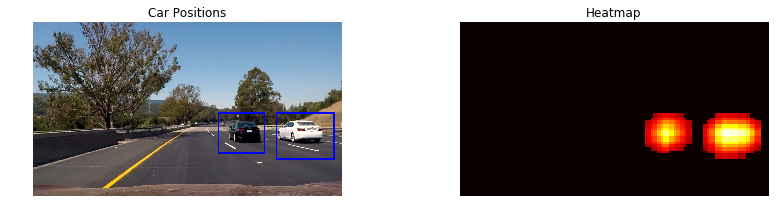

In [362]:
## create empty heatmap
heat_mask = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat_mask = add_heat(heat_mask,hot_windows)
    
# Apply threshold to help remove false positives
heat_mask = apply_threshold(heat_mask,7)

# Visualize the heatmap when displaying    
heatmap_img = np.clip(heat_mask, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap_img)
draw_img = draw_labeled_bboxes(np.copy(image_orig), labels)

## plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
f.tight_layout()

ax1.imshow(draw_img)
ax1.axis('off')
ax1.set_title('Car Positions', fontsize=12)

ax2.imshow(heatmap_img, cmap='hot')
ax2.axis('off')
ax2.set_title('Heatmap', fontsize=12)

## save image for write up
# f.savefig("/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/output_images/heatmap.png")

The heatmap strategy works fairly well to control for the noise in our images. We can apply the pipeline to videos now!

## Video Processing

In [352]:
## parameter dictionary
param_dict = {"y_start_stop":[375, 640],
              "window_sizes":[64, 96, 156],
              "scale":1.5,
              "clf":rf_final,
              "X_scaler":X_scaler,
              "color_space":'LUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
              "orient":8,
              "pix_per_cell":8,
              "cell_per_block":2,
              "hog_channel":0, # Can be 0, 1, 2, or "ALL"
              "spatial_size":(16, 16),
              "hist_bins":32,
              "hist_range":(0,256),
              "spatial_feat":True,
              "color_feat":True,
              "hog_feat":True,
              "test_flag":True,
              "windows_flag":False,
              "heat_flag":False}

## defining a class to keep track of the previous bounding boxes
class Vehicle_Detector:
    
    ## initial list of variables to be passed in
    y_start_stop = None
    window_sizes = None
    clf = None
    X_scaler = None
    color_space = None
    orient = None
    pix_per_cell = None
    cell_per_block = None
    spatial_size = None
    hist_bins = None
    hog_channel = None
    spatial_feat = None
    color_feat = None
    hog_feat = None
    test_flag = None
    windows_flag = None
    heat_flag = None
    
    ## initialize variables
    def __init__(self, aDict, frames_to_keep=10):
        self.hotbox_hist = deque(maxlen=frames_to_keep)
        self.__dict__.update(aDict)
        
    
    ## defining the pipeline
    def pipeline(self, img):
    
        img_orig = np.copy(img)

        ## convert jpg for test images
        if self.test_flag:
            img = img_orig.astype(np.float32)/255

        ## create empty windows list
        windows = []

        ## varying overlap
        overlap = [0.75, 0.6, 0.5]

        for idx, window_size in enumerate(self.window_sizes):
            ## find windows at different scales
            temp_windows = slide_window(img, x_start_stop=[None, None], y_start_stop=self.y_start_stop, 
                                   xy_window=(window_size, window_size), xy_overlap=(overlap[idx], overlap[idx]))

            ## adding the new windows
            windows += temp_windows

        ## search windows and classify cars
        hot_windows = search_windows(img, windows, self.clf, self.X_scaler, cspace=self.color_space, 
                                    spatial_size=self.spatial_size, hist_bins=self.hist_bins, 
                                    orient=self.orient, pix_per_cell=self.pix_per_cell, 
                                    cell_per_block=self.cell_per_block, 
                                    hog_channel=self.hog_channel, spatial_feat=self.spatial_feat, 
                                    color_feat=self.color_feat, hog_feat=self.hog_feat)                       

        ## draw boxes around possible cars
        window_img = draw_boxes(img_orig, hot_windows)

        
        ## current image ##
        ## create empty heatmap
        heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

        ## add heat to each box in box list
        heatmap_mask = add_heat(heatmap_mask, hot_windows)

        ## apply threshold to help remove false positives
        heatmap_mask = apply_threshold(heatmap_mask,7)

        ## visualize the heatmap when displaying    
        heat_img = np.clip(heatmap_mask, 0, 255)

        ## find final boxes from heatmap using label function
        labels = label(heat_img)
        _, bbox = draw_labeled_bboxes(np.copy(img_orig), labels, ret_bbox=True)
        
        ## store the box with previous history
        self.hotbox_hist.append(bbox)
        
        
        ## averaging previous boxes ##
        ## create empty heatmap
        heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

        ## add heat to each box in box list
        heatmap_mask = add_heat(heatmap_mask, self.hotbox_hist)

        ## apply threshold to help remove false positives
        heatmap_mask = apply_threshold(heatmap_mask,5)

        ## visualize the heatmap when displaying    
        heat_img = np.clip(heatmap_mask, 0, 255)
        
        ## find final boxes from heatmap using label function
        labels = label(heat_img)
        final_img = draw_labeled_bboxes(np.copy(img_orig), labels, ret_bbox=False)

        if final_img is not None:
            if all([self.windows_flag, self.heat_flag]):
                return window_img, heat_img
            elif self.windows_flag:
                return window_img
            elif self.heat_flag:
                return heat_img
            else:
                return final_img
        else:
            return img
        
    ## efficient pipeline that uses hog subsampling
    def pipeline_efficient(self, img):
     
        img_orig = np.copy(img)
        draw_img = np.copy(img)

        ## convert jpg for test images
        if self.test_flag:
            img = img_orig.astype(np.float32)/255

        img_tosearch = img[self.y_start_stop[0]:self.y_start_stop[1],:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')

        if self.scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/self.scale), np.int(imshape[0]/self.scale)))

        ch1 = ctrans_tosearch[:,:,0]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
        nyblocks = (ch1.shape[0] // self.pix_per_cell) - self.cell_per_block + 1 
        nfeat_per_block = self.orient*self.cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.pix_per_cell) - self.cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)

        hot_windows = []

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

                ## just keep channel 0
                hog_features = hog_feat1

                xleft = xpos*self.pix_per_cell
                ytop = ypos*self.pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=self.spatial_size)
                rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=self.hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = clf.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*self.scale)
                    ytop_draw = np.int(ytop*self.scale)
                    win_draw = np.int(window*self.scale)

                    bbox = ((xbox_left, ytop_draw+self.y_start_stop[0]), (xbox_left+win_draw,ytop_draw+win_draw+self.y_start_stop[0]))

                    ## store the bounding box if its a car
                    hot_windows.append(bbox)
                    cv2.rectangle(draw_img,bbox[0], bbox[1],(0,0,255),6)


        ## create empty heatmap
        heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

        ## add heat to each box in box list
        heatmap_mask = add_heat(heatmap_mask, hot_windows)

        ## apply threshold to help remove false positives
        heatmap_mask = apply_threshold(heatmap_mask,3)

        ## visualize the heatmap when displaying    
        heat_img = np.clip(heatmap_mask, 0, 255)

        ## find final boxes from heatmap using label function
        labels = label(heat_img)
        _, clean_bbox = draw_labeled_bboxes(np.copy(img_orig), labels, ret_bbox=True)
        
        
        ## store the box with previous history
        self.hotbox_hist.append(clean_bbox)
        
        
        ## create empty heatmap
        heatmap_mask = np.zeros_like(img_orig[:,:,0]).astype(np.float)

        ## add heat to each box in box list
        heatmap_mask = add_heat(heatmap_mask, list(chain.from_iterable(self.hotbox_hist)))

        ## apply threshold to help remove false positives
        heatmap_mask = apply_threshold(heatmap_mask,3)

        ## visualize the heatmap when displaying    
        heat_img = np.clip(heatmap_mask, 0, 255)

        ## find final boxes from heatmap using label function
        labels = label(heat_img)
        final_img = draw_labeled_bboxes(np.copy(img_orig), labels, ret_bbox=False)

        if all([self.windows_flag,self.heat_flag]):
            return draw_img, heat_img
        elif self.windows_flag:
            return draw_img
        elif self.heat_flag:
            return heat_img
        elif final_img is not None:
            return final_img
        else:
            return img

In [255]:
## import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

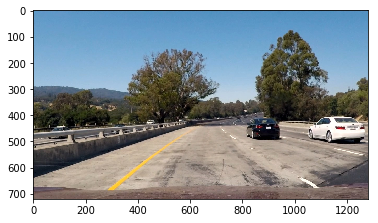

In [350]:
## read in image to test
jpg_image = cv2.imread(test_imgs[0])
jpg_image = cv2.cvtColor(jpg_image, cv2.COLOR_BGR2RGB)

## initializing the detector
veh_detector = Vehicle_Detector(param_dict)

plt.imshow(veh_detector.pipeline_efficient(jpg_image))

In [353]:
## initialize detector
veh_detector = Vehicle_Detector(param_dict)

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(veh_detector.pipeline_efficient) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [31:06<00:01,  1.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 30min 38s, sys: 40.9 s, total: 31min 19s
Wall time: 31min 6s


## Pickle Files
Storing models and data that we might need later on

In [266]:
## pickle model
joblib.dump(rf_final, '/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/pickles/rf_final.pkl')

## pickle scaler
joblib.dump(X_scaler, '/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/pickles/X_scaler.pkl')

## pickle data dictionary
data_dict = {"veh_images":veh_images, "add_veh_images":add_veh_images, "nonveh_images":nonveh_images}
joblib.dump(data_dict, '/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/pickles/data_dict.pkl')

## pickle param dictionary
param_dict = {"y_start_stop":[375, 640],
              "window_sizes":[64, 96, 156],
              "scale":1.5,
              "clf":rf_final,
              "X_scaler":X_scaler,
              "color_space":'LUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
              "orient":8,
              "pix_per_cell":8,
              "cell_per_block":2,
              "hog_channel":0, # Can be 0, 1, 2, or "ALL"
              "spatial_size":(16, 16),
              "hist_bins":32,
              "hist_range":(0,256),
              "spatial_feat":True,
              "color_feat":True,
              "hog_feat":True,
              "test_flag":False,
              "windows_flag":False,
              "heat_flag":False}
joblib.dump(param_dict, '/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/pickles/param_dict.pkl')

['/Users/jwen/Courses/sdcnd/sdcnd_vehicle_detection/pickles/param_dict.pkl']